
# Making Sense out of QuadraticDiscriminantAnalysis

OK, let's see if we can make sense of how the `QuadraticDiscriminantAnalysis` is (and isn't) working.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

ds = load_digits()
Xs = ds.data
ys = ds.target

We can use the `store_covariance` argument to tell `QuadraticDiscriminantAnalysis` to store the full covariance matrices for all ten classes. Then we can inspect them to see if they are full rank (i.e. with 64 non-zero eigenvalues) or not.

In [2]:
# Fit the QDC with no regularization and store the full covariance matrices.
qdc = QuadraticDiscriminantAnalysis(store_covariance=True, reg_param=0.0)
qdc.fit(Xs, ys)
print(f'Covariance Ranks: {[np.linalg.matrix_rank(S) for S in qdc.covariance_]}')

Covariance Ranks: [48, 51, 54, 54, 53, 51, 48, 49, 52, 54]


C:\Users\lucia\anaconda3\envs\FML\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


And we see that, in fact, NONE of the estimated covariance matrices are full-rank. If we use `reg_param` this should change.

In [50]:
# Fit the QDC with regularization and store the full covariance matrices.
qdc = QuadraticDiscriminantAnalysis(store_covariance=True, reg_param=0.01)
qdc.fit(Xs, ys)
print(f'Covariance Ranks: {[np.linalg.matrix_rank(S) for S in qdc.covariance_]}')

Covariance Ranks: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64]


/home/bagdanov/software/miniconda3/envs/FML/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Yes! We have full-rank matrices... But the warning persists. Looking at the code around that line where the warning is thrown in `discriminant_analysis` we see:

````
            _, S, Vt = np.linalg.svd(Xgc, full_matrices=False)
            rank = np.sum(S > self.tol)
            if rank < n_features:
                warnings.warn("Variables are collinear")
            S2 = (S**2) / (len(Xg) - 1)
            S2 = ((1 - self.reg_param) * S2) + self.reg_param

````

And we can see that the warning is thrown **before** the regularization is applied. Scikit-learn is warning us that our **original** data is not full rank.

We should see better results with regularized covariance.

Text(0, 0.5, 'CV Accuracy')

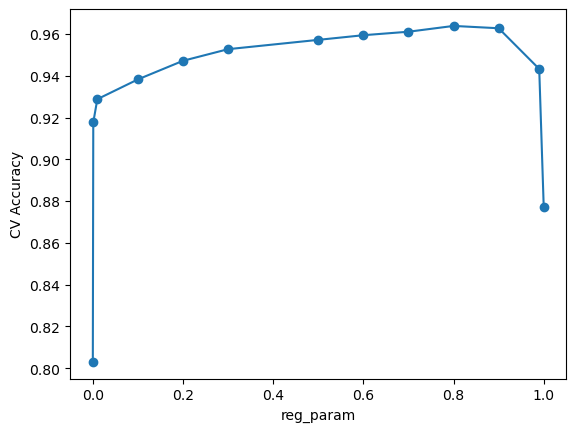

In [3]:
%%capture --no-display
# This Jupyter magic above suppresses printing (but not plots) in this cell.

# Try a broad range of reg_param.
reg_params = [0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1.0]
cv_scores = [cross_val_score(QuadraticDiscriminantAnalysis(reg_param=r), Xs, ys) for r in reg_params]
plt.plot(reg_params, np.mean(cv_scores, 1), '-o')
plt.xlabel('reg_param')
plt.ylabel('CV Accuracy')

At very low values of `reg_param` some (or all) covariance matrices are still close to singular. Then, regularization is working for a while, and then for **high** values of `reg_param` are are over-regularizing (all covariance matrices are close to the identity matrix).

**TL;DR**: We can ignore the warning, but we **cannot** ignore regularization!